**Import Library**

In [41]:
import warnings
warnings.filterwarnings("ignore")

import re
import pandas as pd
import nltk
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import emoji
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

<h1>Baca Data<h1>

In [42]:
df = pd.read_csv("manual_label.csv")
label_col = "label"
total_data = len(df)
labeled = df[label_col].notna().sum()
unlabeled = df[label_col].isna().sum()
label_counts = df[label_col].value_counts()

print("==== Statistik Labeling ====")
print(f"Total data              : {total_data}")
print(f"Label manual            : {labeled}")
print(f"Label self training     : {unlabeled}")
print("\n=== Total per label ===")
print(label_counts)

==== Statistik Labeling ====
Total data              : 1000
Label manual            : 250
Label self training     : 750

=== Total per label ===
label
positive    100
negative    100
neutral      50
Name: count, dtype: int64


<h1>Membersihkan Data yang Kurang Relevant dan Hpus Duplikat</h1>

In [43]:
# Daftar kata kunci relevan dan tidak relevan untuk Fish It
topic_keywords = [
    "fish it", "fishit", "fishing", "roblox", "fish", "rod", "bait", "boat", "merchant",
    "secret", "ancient whale", "megalodon", "island", "jungle", "coral reef", "stingray shores",
    "kohana", "mutation", "shiny", "potion", "luck", "enchant", "battlepass", "admin event",
    "halloween event", "update", "f2p", "skin", "crab", "lobster"
]

irrelevant_keywords = [
    "download", "promo", "iklan", "klik link", "aplikasi", "follow", 
    "giveaway", "voucher", "diskon", "gratis", "registrasi", "daftar", "event", "joki"
]

# Fungsi untuk mengecek relevansi
def is_relevant(text):
    text_lower = text.lower()
    if any(bad in text_lower for bad in irrelevant_keywords):
        return False
    return any(topic in text_lower for topic in topic_keywords)

# Load data dari data.csv
df = pd.read_csv("manual_label.csv")

# Langkah 1: Hapus duplikat berdasarkan teks asli
df = df.drop_duplicates(subset="full_text").reset_index(drop=True)

# Langkah 2: Filter data relevan
mask = df["full_text"].astype(str).apply(is_relevant)
df = df[mask].reset_index(drop=True)

# Simpan teks yang sudah difilter
texts = df["full_text"].astype(str)

# Cetak jumlah data setelah deduplikasi dan pembersihan topik
print(f"Jumlah data setelah deduplikasi dan pembersihan topik: {len(df)} baris tersisa.")

# Simpan hasil ke file CSV
texts.to_csv("deduplicated_fishit_data.csv", index=False)

Jumlah data setelah deduplikasi dan pembersihan topik: 1000 baris tersisa.


<h1>PraPemrosesan import Stemmer dari Sastrawi dan Stopwords</h1>

In [44]:
# --- STOPWORD & STEMMER ---
stop_factory = StopWordRemoverFactory()
stop_sastrawi = set(stop_factory.get_stop_words())
stop_nltk = set(stopwords.words('indonesian'))

# Tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# --- TAMBAH STOPWORD GAUL & UMUM (TAMBAH KOMA!) ---
manual_stopwords = {
    'aku', 'nya', 'oke', 'aja', 'saya', 'sih', 'doang', 'gw', 'gua', 'aq', 
    'kamu', 'lu', 'loe', 'km', 'kmu', 'iya', 'ya', 'yah', 'nih', 'dong', 
    'lah', 'kah', 'deh', 'ajah', 'aj', 'gak', 'ga', 'gk', 'ngga', 'tp', 
    'tpi', 'sm', 'sma', 'lg', 'lgi', 'udh', 'udah', 'dah', 'blm', 'blom',
    'klo', 'kalo', 'kl', 'gt', 'gtu', 'gini', 'gmn', 'gimana', 'wkwk', 
    'haha', 'hehe', 'huhu', 'anjir', 'anjing', 'bjir', 'cok', 'coy', 
    'dm', 'btw', 'pls', 'plis', 'brp', 'brpa', 'kak', 'bang', 'bro', 
    'sis', 'pun', 'mah', 'tu', 'nih', 'https', 'http', 'www', 'co', 
    'id', 'net', 'org', 'yuk', 'ken', "gue", "guys", "tau", "tuh", "daki",
    "biar", "kali", "banget", 'mending', 'gitu', "kakak", "pas", "karena",
    "ayo", "semoga", "kena", "ajaa", "gara gara", "sender", "gara", "pake", 
    "emang", "txtfromroblox", "by the way", "karna", "avqris avrekber okii"
}

# --- KATA KUNCI FISH IT (JANGAN DIHAPUS!) ---
topic_keywords = {
    'fish', 'secret', 'kraken', 'megalodon', 'afk', 'mancing', 'pancingan',
    'trade', 'enchant', 'zona', 'uang', 'mitos', 'roblox', 'server', 'luck',
    'talon', 'potion', 'shiny', 'mutation', 'boat', 'bait', 'merchant',
    'island', 'jungle', 'coral', 'stingray', 'kohana', 'shores', 'battlepass',
    'halloween', 'update', 'f2p', 'skin', 'crab', 'lobster'
}

# --- GABUNG STOPWORD ---
stop_words = (stop_nltk.union(stop_sastrawi).union(manual_stopwords)) - topic_keywords

# --- STEMMER ---
stemmer = StemmerFactory().create_stemmer()

In [45]:
def case_folding(text):
    text = text.lower()
    return text

# Kamus untuk perbaikan typo, singkatan
corrections = {
    # Gaul umum (dari kode asli + tambah)
    "anjir": "anjing", "anjg": "anjing", "anj": "anjing", "jir": "anjing", "bjir": "anjing", "ajg": "anjing", "anjay": "anjing",
    "wtf": "apa", "lol": "tertawa", "wkwk": "tertawa", "wkwkwk": "tertawa", "haha": "tertawa", "hahaha": "tertawa", "hehe": "tertawa",
    "gw": "gue", "gua": "gue",  "ak": "aku", "aq": "aku", "ku": "aku", "lu": "kamu", "loe": "kamu", "km": "kamu", "kmu": "kamu",
    "gak": "tidak", "ga": "tidak", "gk": "tidak", "ngga": "tidak", "bgt": "banget", "bgtt": "banget", "bngt": "banget",
    "tp": "tapi", "tpi": "tapi", "sm": "sama", "sma": "sama", "lg": "lagi", "lgi": "lagi", "udh": "sudah", "udah": "sudah", "dah": "sudah",
    "blm": "belum", "blom": "belum", "bkn": "bukan", "klo": "kalau", "kalo": "kalau", "kl": "kalau", "aj": "aja",
    "dapet": "dapat", "dpt": "dapat", "dpet": "dapat", "daper": "dapat", "dptn": "dapat", "pancingan": "pancing", "pancingn": "pancingan",
    "menginap": "inap", "maleman": "malam", "bjil": "anjing", "ngestuck": "stuck",
    "afk": "away from keyboard", "gess": "guys", "uhuy": "uhuy", "shibaal": "sial", "gamood": "gamau", "fagh": "fuck",
    "mulu": "terus", "blom": "belum", "juseyo": "tolong", "wangi": "bagus", "aowkowwkok": "tertawa",
    "redfinger": "redfinger", "betmut": "batas mutu", "hcketawa": "tertawa", "kaga": "tidak",
    "semalem": "semalam", "btw": "by the way", "grub": "group", "ngebug": "bug", "makas": "terima kasih", "makasi": "terima kasih",
    "gosrek": "ghost shark", "rill": "real", "kinyis": "kinclong", "mr": "mister", "diH": "dih", 
    "sung": "langsung", "leavs": "leave", "nambahin": "menambah", "org": "orang", "dpt":"dapat", "org":"orang",
    "eso": "esoteric", "uhuy": "senang", "somnong": "sombong", "mahh": "iya", "bro": "kamu", "utk": "untuk", 
    "bang": "kakak", "sht": "shit", "amp": "dan", "sllu": "selalu", "prtma": "pertama", "rsanya": "rasa", "well": "senang",
    "ktnya": "katanya", "bru": "baru", "bbrpa": "beberapa", "kcnduan": "kecanduan", "ternyta": "ternyata",
    "ssru": "seru", "kai": "kai", "kasih": "berikan", "belom": "belum", "uda": "sudah", "sepulau": "sepulau", "suruh": "disuruh",
    "ginian": "begini", "kotoran": "kotoran", "keknya": "kayaknya", "arung": "mengarungi", "shibaal": "sial", "dah": "sudah", "gamood": "gamau", "fagh": "fuck", "krna": "karena",
    "sinta": "sinta", "open": "open", "grgr": "gara-gara", "ancient": "ancient", "jungle": "jungle", "susah": "susah",
    "bangun": "bangun", "tidur": "tidur", "senagih": "se-nagih", "meledakk": "meledak", 
    "males": "malas",  "engga": "tidak",  "openk": "open", "yuu": "ajak", "nyang": "yang", "bobak": "coba", "gempass": "gamepass",
    "gag": "tidak", "timsar": "timsar", "kelipat": "kelipatan","ettoilest": "ettoilest",
    "waifue": "waife", "knp": "kenapa", "gabisa": "tidak bisa", "pancong": "pancong", "indopopbase": "indo pop base", "narkoboy": "narkoba", "brsm": "bersama", "letjungcook": "lee jungkook",
    "bnr": "benar", "bcs": "karena", "riweuh": "ribet", "bulak": "bolak", "makasihh": "terima kasih", "kakk": "kak", "jga": "juga", "terjun": "terjun", "dikerjain": "dikerjain", "tanggung": "bertanggung jawab",
    "plhiv": "plhiv", "here": "di sini", "makan": "makan", "oil": "oil", "take": "ambil", "ganggu": "ganggu", "ubat": "obat",
    "jap": "sebentar", "takda": "tidak ada",  "number": "nomor", "opang": "opang", "gaa": "tidak",
    "grinding": "grinding", "tinggal": "tinggal", "scroll": "scroll", "tiktok": "tiktok", "nemu": "nemu", "live": "live",
    "aji": "pengajian", "tolak": "bertolak belakang", "cung": "cung", "kerja": "kerja", "sambil": "sambil", "anjing": "anjing",
    "diem": "diam", "gausa": "tidak usah", "ucup": "ucup", "org": "orang", "limit": "limit", "astaghfirullah": "astaghfirullah",
    "mula": "pemula", "volcano": "volcano", "salpok": "salpok", "abang": "abang", "batu": "batu", "pusing": "pusing",
    "ninggalin": "meninggalkan", "kli": "kali", "gass": "gas", "acc": "account", "yhh": "ya", "cisi": "cici",
    "cuman": "cuma", "gegara": "gara-gara", "ken": "ingin", "pen" : "ingin", "memberr": "member", "truss": "terus",
    "maen": "main", "baruu": "baru", "rep": "reply", "dm": "direct message",
    "liat": "lihat", "oon": "bodoh", "grgr": "gara-gara", 'mulu':"terus", 'wib':'waktu indonesia barat', "nyari":"cari", "jgn":'tidak', "emg":"memang", "tertawa":"tawa", "nyoba":"coba", "gara gara" :"karena",
    'moga':'semoga', 'gamau':'tidak', 'temen':'teman','bikin':'buat','nanya':'tanya', 'biar':'karena', "mancing":"pancing", "info":"informasi", "pake":"pakai", "narik":"tarik", "letsgoo":"ayo", "ngangkat":"angkat",
    "abis":'habis', "dece": "discord", "rame":"ramai", "adain":"ada", "nyalain":"nyala", "temenku":"teman aku"

}

gaul = {
    
}

<h1>Pembersihan data menggunakan case folding CPMK 2<h1>

In [46]:
def case_folding(text):
    text = text.lower()
    return text

df_new = pd.DataFrame({
    "full_text": texts,
    "case_folding": texts.apply(case_folding)
})

df_new.to_csv("data_casefolding.csv", index=False)

<h1>Preprocessing regex, tokenisasi dan pemakaian stemmer CPMK 3<h1>

In [47]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b(fish it|fishit|fish|ikan|ikan itu|ikanitu)\b', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'http\S+|www\S+', ' ', text)     
    text = re.sub(r'@\w+', ' ', text)                
    text = emoji.demojize(text)                      
    text = re.sub(r'\d+', ' ', text)                 
    text = re.sub(r'[^\w\s]', ' ', text)             
    text = re.sub(r'(.)\1{2,}', r'\1', text)         
    text = re.sub(r'\s+', ' ', text).strip()         

    tokens = tokenizer.tokenize(text)

    tokens = [corrections.get(w, w) for w in tokens if w not in corrections or corrections[w] != ""]

    tokens = [token for token in tokens if len(token) >= 3]

    tokens = [w for w in tokens if w not in stop_words]

    tokens = [stemmer.stem(w) for w in tokens]

    return " ".join(tokens)

df["preprocessing"] = texts.apply(clean_text)

In [48]:
df_new = pd.DataFrame({
    "full_text": texts,
    "case_folding CPMK2": texts.apply(case_folding),
    "preprocessing CPMK3": df["preprocessing"]
})

df_new.to_csv("data.csv", index=False)

<h1>N-Gram CPMK 4</h1>

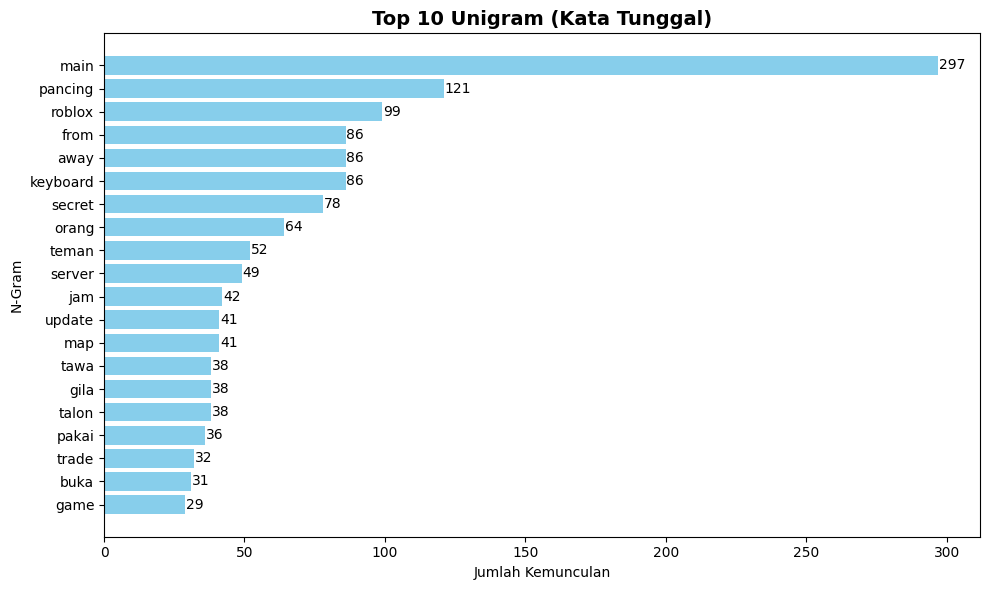

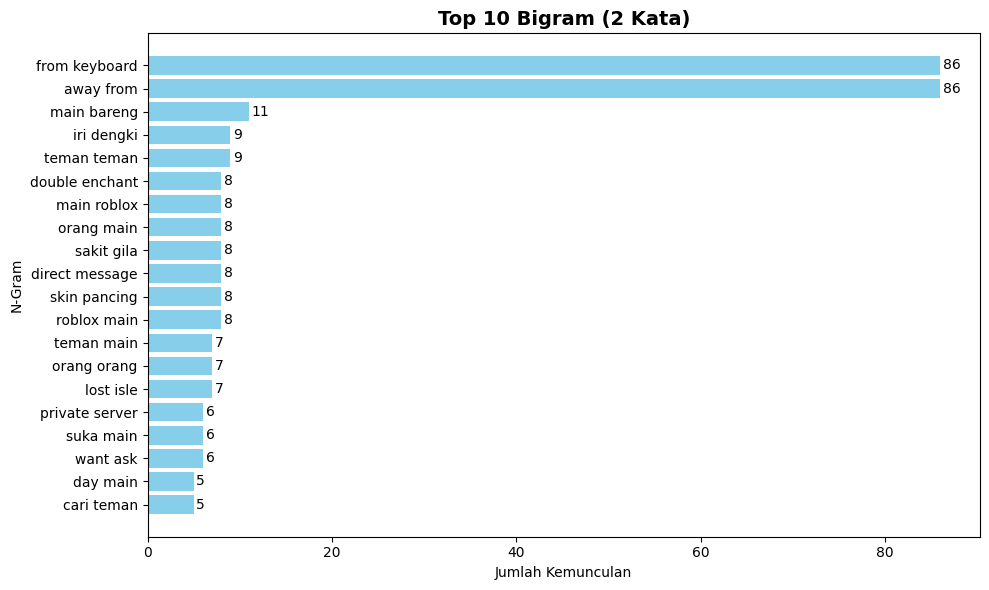

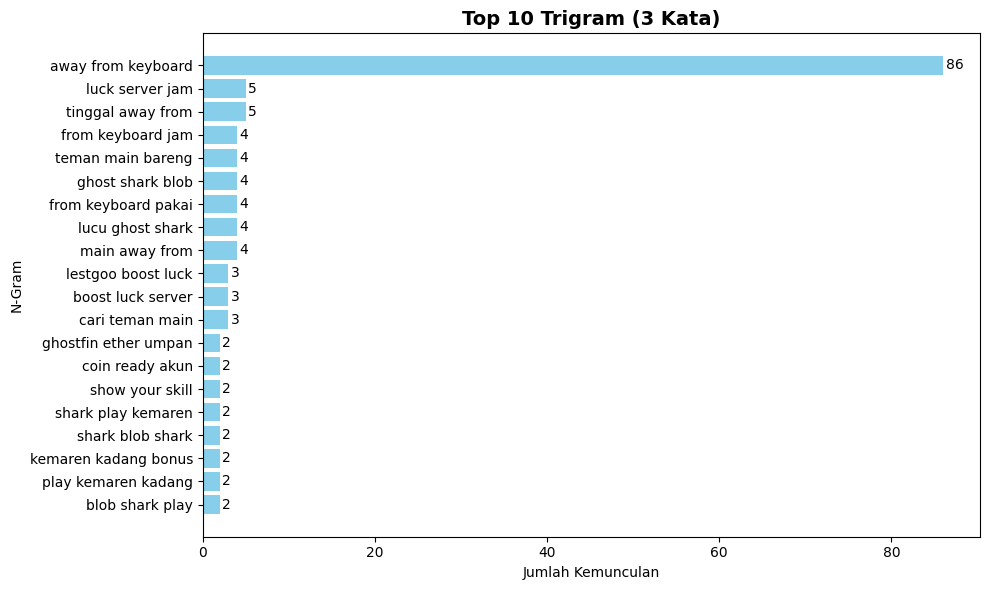

In [49]:
corpus = df['preprocessing'].tolist()

def plot_horizontal_bar_ngram(corpus, ngram_range, title, top_n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=list(stop_words))
    X = vec.fit_transform(corpus)
    freq = X.sum(axis=0).A1
    ngrams = vec.get_feature_names_out()
    df_ngram = pd.DataFrame({'ngram': ngrams, 'count': freq})
    df_ngram = df_ngram.sort_values(by='count', ascending=True).tail(top_n)
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(df_ngram['ngram'], df_ngram['count'], color='skyblue')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Jumlah Kemunculan')
    plt.ylabel('N-Gram')
    
    # Tambah angka di ujung batang
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
                 str(df_ngram['count'].iloc[i]), va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Jalankan untuk 3 n-gram
plot_horizontal_bar_ngram(corpus, (1,1), "Top 10 Unigram (Kata Tunggal)", 20)
plot_horizontal_bar_ngram(corpus, (2,2), "Top 10 Bigram (2 Kata)", 20)
plot_horizontal_bar_ngram(corpus, (3,3), "Top 10 Trigram (3 Kata)", 20)

<h1>WorldCloud CPMK 4</h1>

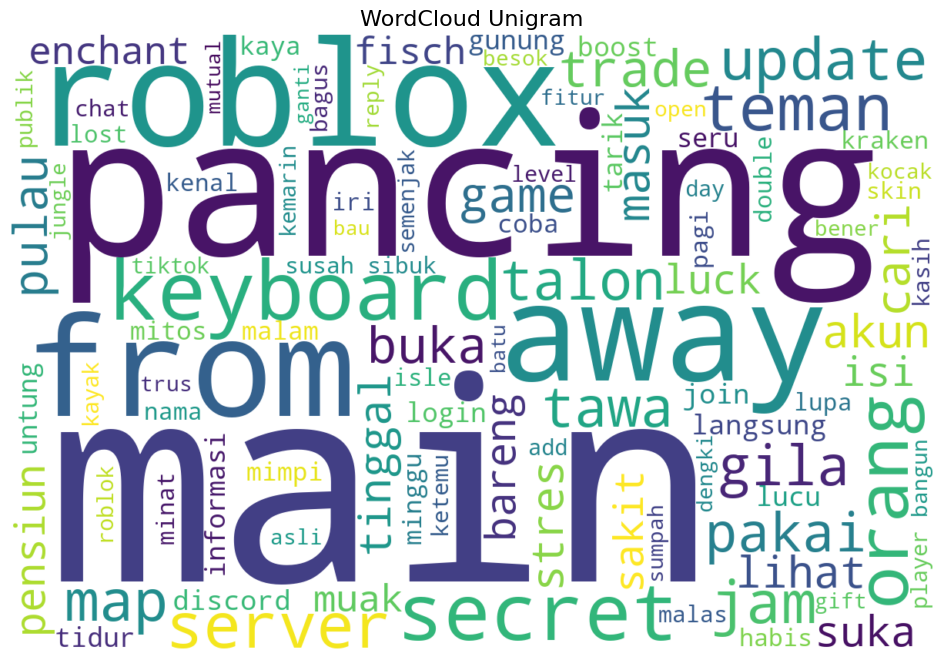

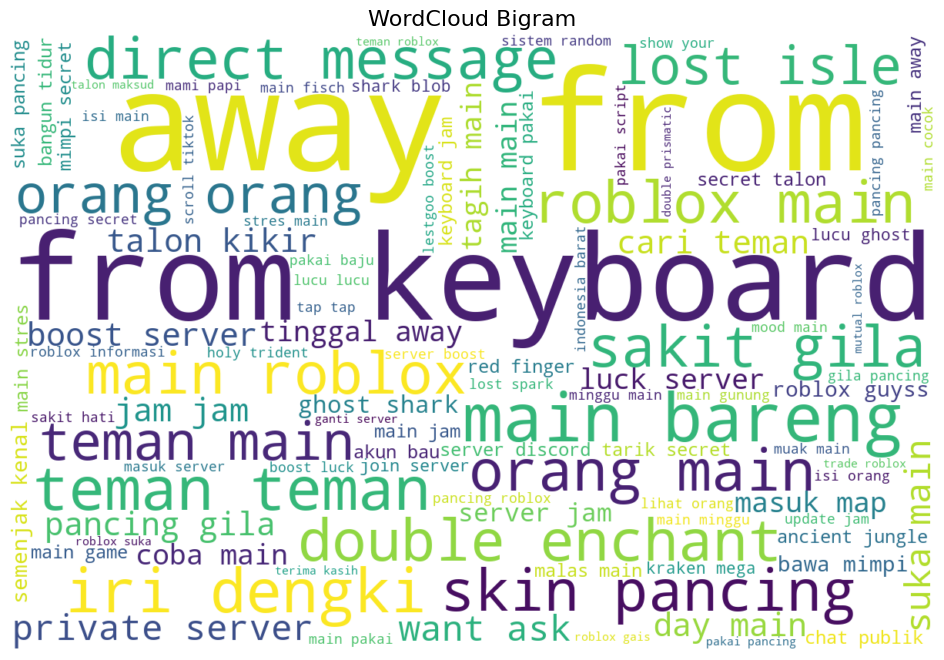

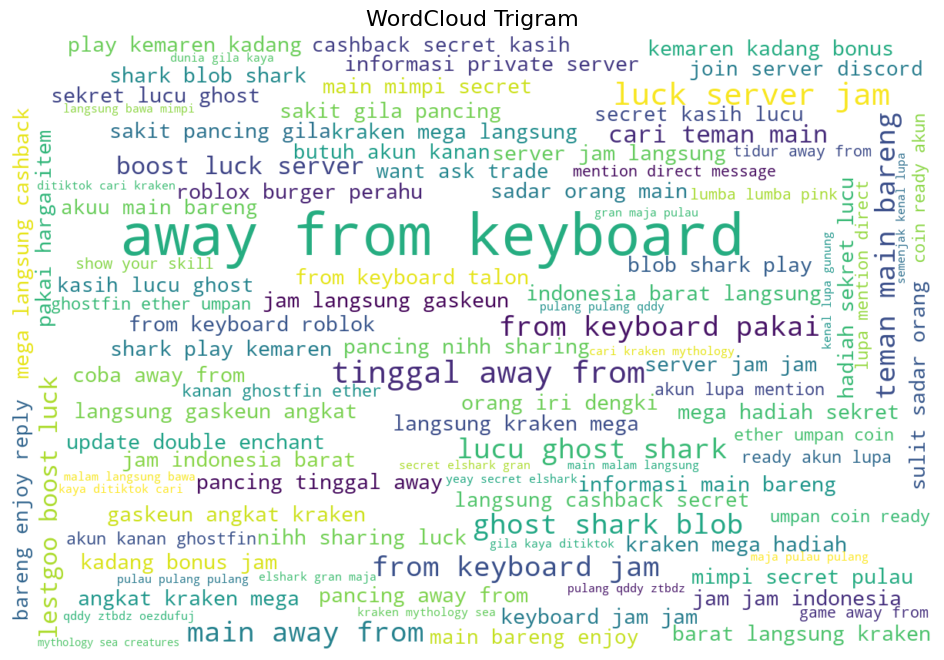

In [50]:
# Fungsi wordcloud n-gram (1,2,3) dengan filter "fish it" (sudah di prepro)
def generate_ngram_wordcloud(corpus, ngram_range=(1,1), title="WordCloud"):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=list(stop_words)).fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:100]  # Top 100
    freq_dict = dict(words_freq)
    
    plt.figure(figsize=(12,8))
    wc = WordCloud(width=1200, height=800, background_color='white', max_words=100).generate_from_frequencies(freq_dict)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Generate
generate_ngram_wordcloud(corpus, (1,1), "WordCloud Unigram")
generate_ngram_wordcloud(corpus, (2,2), "WordCloud Bigram")
generate_ngram_wordcloud(corpus, (3,3), "WordCloud Trigram")

<h1>Labeling Data</h1>

Label Manual

In [51]:
#Library
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import train_test_split

In [52]:
labeled_df = df[df["label"].notna()]
unlabeled_df = df[df["label"].isna()]
print("Total labeled:", len(labeled_df))
print("Total unlabeled:", len(unlabeled_df))

Total labeled: 250
Total unlabeled: 750


In [53]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_labeled = vectorizer.fit_transform(labeled_df["preprocessing"].astype(str))
y_labeled = labeled_df["label"].astype(str)

X_unlabeled = vectorizer.transform(unlabeled_df["preprocessing"].astype(str))

In [54]:
base_clf = LogisticRegression(max_iter=500)

self_training_model = SelfTrainingClassifier(
    base_clf,
    threshold=0.95,
    verbose=True
)

In [55]:
X_all = np.vstack([X_labeled.toarray(), X_unlabeled.toarray()])

y_all = pd.concat([
    y_labeled,
    pd.Series([-1] * len(unlabeled_df))
], ignore_index=True)

self_training_model.fit(X_all, y_all)

SelfTrainingClassifier(base_estimator=LogisticRegression(max_iter=500),
                       threshold=0.95, verbose=True)

In [56]:
pseudo_labels = self_training_model.predict(X_unlabeled)
pseudo_probs = self_training_model.predict_proba(X_unlabeled).max(axis=1)

unlabeled_df["pseudo_label"] = pseudo_labels
unlabeled_df["confidence"] = pseudo_probs

In [57]:
final_df = pd.concat([
    labeled_df.rename(columns={"label": "final_label"}),
    unlabeled_df.rename(columns={"pseudo_label": "final_label"})
], ignore_index=True)

final_df.to_csv("self_training_label.csv", index=False)

print("\n=== LABEL DISTRIBUTION AFTER SELF TRAINING ===")
print(final_df["final_label"].value_counts())


=== LABEL DISTRIBUTION AFTER SELF TRAINING ===
final_label
positive    495
negative    446
neutral      59
Name: count, dtype: int64


In [58]:
df_label = pd.read_csv("self_training_label.csv")

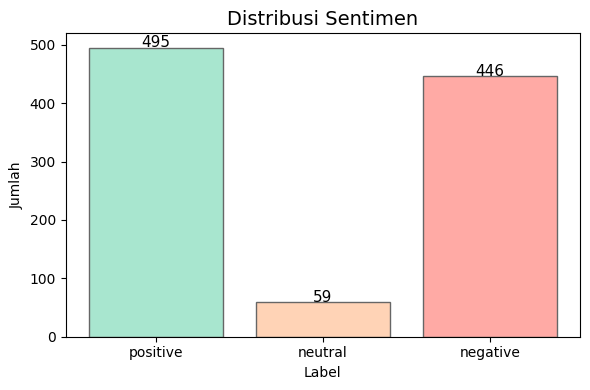

In [59]:
label_counts = df_label["final_label"].value_counts()
order = ["positive", "neutral", "negative"]
counts_ordered = [label_counts.get(lbl, 0) for lbl in order]

# Soft pastel colors
colors = ["#A8E6CF", "#FFD3B6", "#FFAAA5"]  # mint, peach, soft red

plt.figure(figsize=(6,4))
bars = plt.bar(order, counts_ordered, color=colors, edgecolor='#666666', linewidth=1)

# Tambahkan label jumlah di atas bar (opsional)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.5,
             str(height),
             ha='center',
             fontsize=11)

plt.title("Distribusi Sentimen", fontsize=14)
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()
